In [1]:
import sys
sys.path.append('../')

import logging
import os
import unittest

import numpy as np
import torch
import torchvision as tv
import matplotlib.pyplot as plt

from aad.attacks import FGSMContainer
from aad.basemodels import ModelContainerPT, CifarResnet50
from aad.datasets import DATASET_LIST, DataContainer
from aad.defences import FeatureSqueezing
from aad.utils import get_data_path, get_l2_norm, get_range, master_seed, swap_image_channel

%load_ext autoreload
%autoreload 2

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [2]:
SEED = 4096
BATCH_SIZE = 128
NAME = 'CIFAR10'
SQUEEZING_METHODS = ['median']
DATA_ROOT = os.path.join('..', 'data')
MODEL_FILE = os.path.join('..', 'save', 'CifarResnet50_CIFAR10_e30.pt')

In [3]:
master_seed(SEED)

In [5]:
model = CifarResnet50()
dc = DataContainer(DATASET_LIST[NAME], DATA_ROOT)
dc()
mc = ModelContainerPT(model, dc)
mc.load(MODEL_FILE)
accuracy = mc.evaluate(dc.x_test, dc.y_test)
logger.info('Accuracy on test set: %f', accuracy)

Files already downloaded and verified
Files already downloaded and verified
INFO:aad.datasets.data_container:Train size: 50000 - Test size: 10000
INFO:aad.datasets.data_container:Successfully load data. Time to complete: 0m 5.523s
INFO:aad.basemodels.model_container_pt:Loaded model from ../save/CifarResnet50_CIFAR10_e30.pt
INFO:__main__:Accuracy on test set: 0.819600


In [6]:
def imshow(tensor_grid, mean=0., std=1., title=None):
    assert isinstance(tensor_grid, torch.Tensor)
    assert len(tensor_grid.size()) == 4, \
        f'For a batch of images only, {tensor_grid.size()} '
    
    tensor_grid = tv.utils.make_grid(tensor_grid)
    grid = tensor_grid.numpy().transpose((1,2,0))
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)

In [7]:
x_range = get_range(dc.x_train)
squeezer = FeatureSqueezing(
    mc,
    clip_values=x_range,
    smoothing_methods=SQUEEZING_METHODS,
    bit_depth=8,
    sigma=0.1,
    kernel_size=3,
    pretrained=True,
)

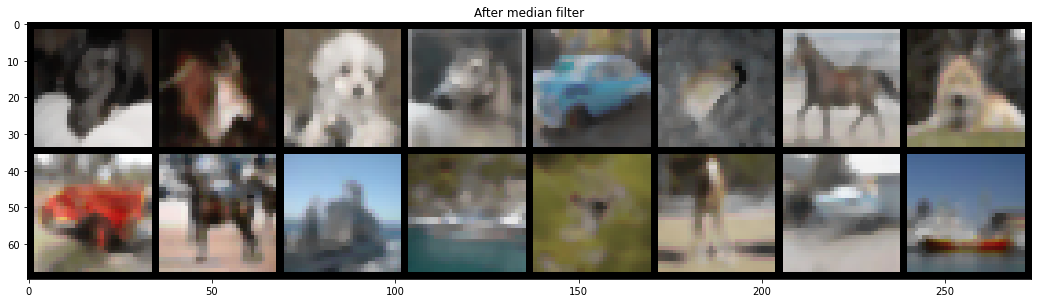

In [8]:
squeezing_model = squeezer.get_def_model_container('median')
x_train = squeezing_model.data_container.x_train
images = x_train[:16]

plt.figure(figsize=[18, 18])
imshow(torch.from_numpy(swap_image_channel(images)), title='After median filter')
plt.show()